In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier

In [68]:
df = pd.read_csv("./../../Dataset/Final-dataset-vector/faceswap.csv")

In [69]:
df["has_smells"] = df["has_smells"].apply(lambda x: list(map(int, x.strip("[]").split(","))))

                                  Absent (0)  Présent (1)
Scattered Functionality                  953           83
Potential Improper API Usage             712          324
Potential Redundant Abstractions        1023           13
Orphan Module                            956           80
Unstable Dependency                      709          327
God Object                               979           57


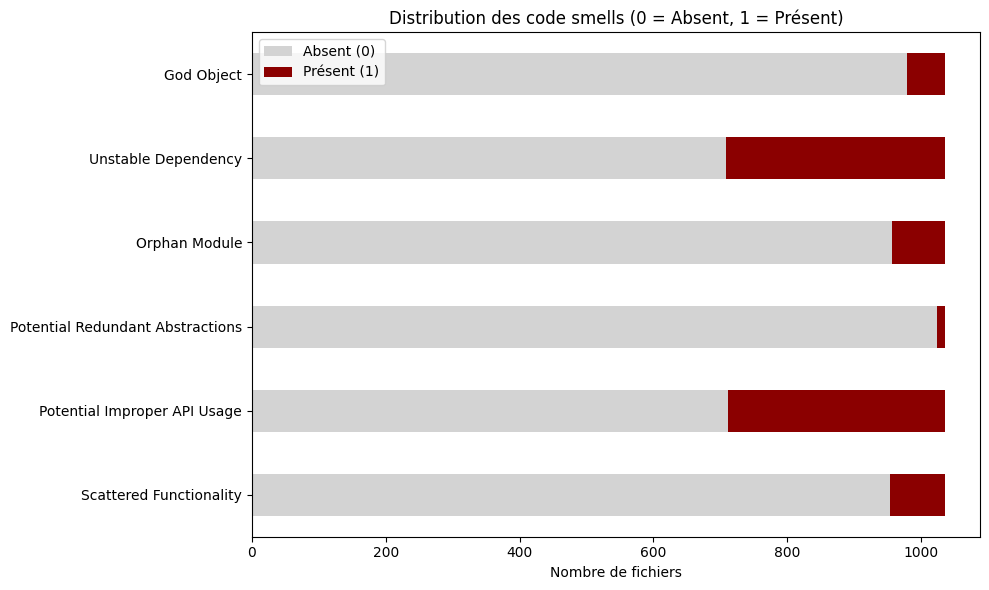

In [70]:
smell_labels = [
    "Scattered Functionality",
    "Potential Improper API Usage", 
    "Potential Redundant Abstractions",
    "Orphan Module",
    "Unstable Dependency",
    "God Object"
]

# Transformer la colonne en plusieurs colonnes
smells_df = pd.DataFrame(df["has_smells"].tolist(), columns=smell_labels)

# Afficher la distribution de 1 et 0 pour chaque smell
distribution = smells_df.apply(pd.Series.value_counts).T.fillna(0).astype(int)
distribution.columns = ['Absent (0)', 'Présent (1)']

# Affichage
print(distribution)

# Affichage graphique
distribution.plot(kind='barh', stacked=True, figsize=(10, 6), color=['lightgray', 'darkred'])
plt.xlabel("Nombre de fichiers")
plt.title("Distribution des code smells (0 = Absent, 1 = Présent)")
plt.tight_layout()
plt.show()

In [71]:
X = df[["line_count", "method_count", "coupling_score"]]
y = np.array(df["has_smells"].tolist())

In [72]:
# Splitting the dataset into the Training set and the Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [74]:
class CustomMLPClassifier(BaseEstimator, ClassifierMixin):
    """
    Wrapper MLP compatible avec multi-output
    """
    def __init__(self, hidden_layer_sizes=(64, 32), max_iter=100, random_state=42):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.max_iter = max_iter
        self.random_state = random_state
        self.model = None
        
    def fit(self, X, y):
        print(f"Training CustomMLPClassifier with input shape: {X.shape}, output shape: {y.shape}")
        
        self.model = MultiOutputClassifier(
            MLPClassifier(
                hidden_layer_sizes=self.hidden_layer_sizes,
                max_iter=self.max_iter,
                random_state=self.random_state,
                early_stopping=True,
                validation_fraction=0.2,
                n_iter_no_change=10
            )
        )
        
        self.model.fit(X, y)
        print("CustomMLPClassifier training completed")
        return self
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before prediction")
        return self.model.predict(X)
    
    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model must be fitted before prediction")
        # Les probabilités pour multi-output
        probas = []
        for estimator in self.model.estimators_:
            proba = estimator.predict_proba(X)[:, 1]  # Probabilité de la classe 1
            probas.append(proba)
        return np.column_stack(probas)

# ANN Model

In [75]:
ann_model = CustomMLPClassifier(hidden_layer_sizes=(64, 32), max_iter=100, random_state=42)

In [76]:
# Train the MLP model
ann_model.fit(X_train_scaled, y_train)

Training CustomMLPClassifier with input shape: (828, 3), output shape: (828, 6)
CustomMLPClassifier training completed


,hidden_layer_sizes,"(64, ...)"
,max_iter,100
,random_state,42


In [77]:
from sklearn.metrics import confusion_matrix

y_pred_ann = ann_model.predict(X_test_scaled)
print("Exact Match Accuracy:", accuracy_score(y_test, y_pred_ann))  # tous labels corrects = 1
print("Classification Report:\n", classification_report(y_test, y_pred_ann, target_names=smell_labels, zero_division=0))

for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_ann[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")

Exact Match Accuracy: 0.4182692307692308
Classification Report:
                                   precision    recall  f1-score   support

         Scattered Functionality       0.00      0.00      0.00        26
    Potential Improper API Usage       0.70      0.63      0.66        73
Potential Redundant Abstractions       0.00      0.00      0.00         1
                   Orphan Module       0.00      0.00      0.00        17
             Unstable Dependency       0.64      0.28      0.39        74
                      God Object       0.00      0.00      0.00        12

                       micro avg       0.68      0.33      0.44       203
                       macro avg       0.22      0.15      0.18       203
                    weighted avg       0.48      0.33      0.38       203
                     samples avg       0.21      0.14      0.17       203

Confusion Matrix for Scattered Functionality:
[[182   0]
 [ 26   0]]

Confusion Matrix for Potential Improper API Usag

# Random Forest Model

In [78]:
rf_base = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model = MultiOutputClassifier(rf_base)

In [79]:
rf_model.fit(X_train_scaled, y_train)
y_pred_forest = rf_model.predict(X_test_scaled)

In [80]:
# Évaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Exact Match Accuracy (RF):", accuracy_score(y_test, y_pred_forest))
print("Classification Report (RF):\n", classification_report(y_test, y_pred_forest, target_names=smell_labels, zero_division=0))

# Confusion matrix par label
for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_forest[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")

Exact Match Accuracy (RF): 0.5144230769230769
Classification Report (RF):
                                   precision    recall  f1-score   support

         Scattered Functionality       0.69      0.42      0.52        26
    Potential Improper API Usage       0.64      0.56      0.60        73
Potential Redundant Abstractions       0.50      1.00      0.67         1
                   Orphan Module       0.76      0.94      0.84        17
             Unstable Dependency       0.57      0.49      0.53        74
                      God Object       0.42      0.42      0.42        12

                       micro avg       0.62      0.54      0.58       203
                       macro avg       0.60      0.64      0.60       203
                    weighted avg       0.62      0.54      0.57       203
                     samples avg       0.34      0.30      0.31       203

Confusion Matrix for Scattered Functionality:
[[177   5]
 [ 15  11]]

Confusion Matrix for Potential Imprope

# Code Stacking avec SVR

In [81]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor

class SVRConfidenceClassifier(BaseEstimator, ClassifierMixin):
    """
    SVR wrapper qui prédit des scores de confiance entre 0 et 1
    puis les convertit en classifications binaires
    """
    def __init__(self, C=1.0, gamma='scale', kernel='rbf'):
        self.C = C
        self.gamma = gamma
        self.kernel = kernel
        self.svr_model = None
        
    def fit(self, X, y):
        print(f"Training SVRConfidenceClassifier with input shape: {X.shape}, output shape: {y.shape}")
        
        # Utiliser MultiOutputRegressor avec SVR pour prédire des scores entre 0 et 1
        self.svr_model = MultiOutputRegressor(
            SVR(kernel=self.kernel, C=self.C, gamma=self.gamma)
        )
        
        # Convertir les labels binaires en float pour la régression
        self.svr_model.fit(X, y.astype(float))
        print("SVRConfidenceClassifier training completed")
        return self
    
    def predict(self, X):
        if self.svr_model is None:
            raise ValueError("Model must be fitted before prediction")
            
        # Prédictions continues
        continuous_pred = self.svr_model.predict(X)
        
        # Clipper entre 0 et 1, puis appliquer seuil à 0.5
        clipped_pred = np.clip(continuous_pred, 0, 1)
        return (clipped_pred > 0.5).astype(int)
    
    def predict_proba(self, X):
        if self.svr_model is None:
            raise ValueError("Model must be fitted before prediction")
            
        # Retourner les scores continus comme probabilités (clippés entre 0 et 1)
        continuous_pred = self.svr_model.predict(X)
        return np.clip(continuous_pred, 0, 1)


In [82]:
class SimplifiedStackingClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, holdout_fraction=0.2):
        self.holdout_fraction = holdout_fraction
        self.fitted_base_estimators = []
        self.fitted_meta_estimators = []
        
    def fit(self, X, y):
        """
        ÉTAPE 1: Split des données sans stratification pour éviter les problèmes
        ÉTAPE 2: Entraîner les modèles de base (RF + MLP scikit-learn - ZÉRO Keras)
        ÉTAPE 3: Utiliser leurs prédictions pour entraîner les méta-modèles
        """
        print("🔄 Starting stacking training...")
        print(f"Input shapes: X={X.shape}, y={y.shape}")
        
        # ÉTAPE 1: Split stratifié pour mieux préserver les classes rares
        from sklearn.model_selection import train_test_split
        
        try:
            # Essayer split stratifié sur le premier smell (le plus équilibré)
            X_base, X_meta, y_base, y_meta = train_test_split(
                X, y, 
                test_size=self.holdout_fraction, 
                random_state=42, 
                stratify=y[:, 1]  # Stratifier sur "Potential Improper API Usage" (plus équilibré)
            )
            print("✅ Stratified split successful")
        except ValueError as e:
            print(f"⚠️ Stratified split failed: {e}")
            print("Falling back to simple split...")
            # Fallback: split manuel simple
            split_idx = int(len(X) * (1 - self.holdout_fraction))
            X_base = X[:split_idx]
            X_meta = X[split_idx:]
            y_base = y[:split_idx]
            y_meta = y[split_idx:]
        
        print(f"Base set: X_base={X_base.shape}, y_base={y_base.shape}")
        print(f"Meta set: X_meta={X_meta.shape}, y_meta={y_meta.shape}")
        
        # Diagnostic des classes dans les données de meta-learning
        smell_names = ["Scattered Functionality", "Potential Improper API Usage", 
                      "Potential Redundant Abstractions", "Orphan Module",
                      "Unstable Dependency", "God Object"]
        
        print("\n📊 Class distribution in meta-learning set:")
        for i, smell_name in enumerate(smell_names):
            unique, counts = np.unique(y_meta[:, i], return_counts=True)
            class_dist = dict(zip(unique, counts))
            print(f"  {smell_name}: {class_dist}")
            if len(unique) < 2:
                print(f"    🚨 WARNING: Only class {unique[0]} present!")
        
        # ÉTAPE 2: Entraîner les modèles de base
        self.fitted_base_estimators = []
        meta_features_list = []
        
        print("Training Random Forest...")
        # Random Forest avec MultiOutputClassifier
        rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
        rf.fit(X_base, y_base)
        self.fitted_base_estimators.append(('rf', rf))
        rf_meta_pred = rf.predict(X_meta)
        meta_features_list.append(rf_meta_pred)
        print(f"RF predictions shape: {rf_meta_pred.shape}")
        
        print("Training MLP (scikit-learn - NO Keras)...")
        # MLP scikit-learn pur (AUCUNE dépendance Keras/TensorFlow)
        mlp = MultiOutputClassifier(MLPClassifier(hidden_layer_sizes=(64, 32), 
                                                  max_iter=100, 
                                                  random_state=42, 
                                                  early_stopping=True,
                                                  validation_fraction=0.2))
        mlp.fit(X_base, y_base)
        self.fitted_base_estimators.append(('mlp', mlp))
        mlp_meta_pred = mlp.predict(X_meta)
        meta_features_list.append(mlp_meta_pred)
        print(f"MLP predictions shape: {mlp_meta_pred.shape}")
        
        print("Training SVR (Support Vector Regression)...")
        # SVR avec scores de confiance
        svr = SVRConfidenceClassifier(C=1.0, gamma='scale', kernel='rbf')
        svr.fit(X_base, y_base)
        self.fitted_base_estimators.append(('svr', svr))
        svr_meta_pred = svr.predict(X_meta)
        meta_features_list.append(svr_meta_pred)
        print(f"SVR predictions shape: {svr_meta_pred.shape}")
        
        # ÉTAPE 3: Combiner les prédictions de base
        # Forme finale: (n_meta_samples, 3_models * 8_outputs) = (n_meta_samples, 24)
        stacked_meta_features = np.concatenate(meta_features_list, axis=1)
        print(f"Stacked meta features shape: {stacked_meta_features.shape}")
        
        # ÉTAPE 4: Entraîner les méta-estimateurs (un par smell) avec gestion des classes déséquilibrées
        print("Training meta-estimators...")
        self.fitted_meta_estimators = []
        for i in range(y.shape[1]):
            smell_name = ["Scattered Functionality", "Potential Improper API Usage", 
                         "Potential Redundant Abstractions", "Orphan Module",
                         "Unstable Dependency", "Hub-like Dependency",
                         "Cyclic Dependency", "God Object"][i]
            
            print(f"  Training meta-estimator for smell {i+1}/8: {smell_name}")
            
            # Vérifier s'il y a au moins 2 classes dans les données de meta-learning
            unique_classes = np.unique(y_meta[:, i])
            print(f"    Available classes: {unique_classes}")
            
            if len(unique_classes) < 2:
                print(f"    ⚠️ Only one class found for {smell_name}. Using DummyClassifier.")
                # Utiliser un DummyClassifier qui prédit toujours la classe majoritaire
                from sklearn.dummy import DummyClassifier
                meta_est = DummyClassifier(strategy='most_frequent')
                meta_est.fit(stacked_meta_features, y_meta[:, i])
            else:
                # Classes équilibrées : utiliser LogisticRegression normal
                print(f"    ✅ Both classes present. Using LogisticRegression.")
                meta_est = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
                meta_est.fit(stacked_meta_features, y_meta[:, i])
            
            self.fitted_meta_estimators.append(meta_est)
        
        print("✅ Stacking model training completed successfully!")
        return self
    
    def predict(self, X):
        """
        ÉTAPE 1: Obtenir les prédictions des modèles de base
        ÉTAPE 2: Les combiner en features pour les méta-modèles
        ÉTAPE 3: Prédictions finales avec les méta-modèles
        """
        print("Making stacking predictions...")
        
        # ÉTAPE 1: Prédictions des modèles de base
        base_predictions = []
        for name, estimator in self.fitted_base_estimators:
            pred = estimator.predict(X)
            base_predictions.append(pred)
            print(f"{name} predictions shape: {pred.shape}")
        
        # ÉTAPE 2: Combiner les prédictions
        stacked_features = np.concatenate(base_predictions, axis=1)
        print(f"Stacked features shape: {stacked_features.shape}")
        
        # ÉTAPE 3: Prédictions finales
        final_predictions = []
        for i, meta_est in enumerate(self.fitted_meta_estimators):
            pred = meta_est.predict(stacked_features)
            final_predictions.append(pred)
        
        result = np.column_stack(final_predictions)
        print(f"Final predictions shape: {result.shape}")
        return result

In [83]:
# Create the simplified stacking model
stacking_model = SimplifiedStackingClassifier(holdout_fraction=0.2)

In [84]:
# Train the stacking model
print(y_train.shape)
print(np.unique(y_train))

stacking_model.fit(X_train_scaled, y_train)

(828, 6)
[0 1]
🔄 Starting stacking training...
Input shapes: X=(828, 3), y=(828, 6)
✅ Stratified split successful
Base set: X_base=(662, 3), y_base=(662, 6)
Meta set: X_meta=(166, 3), y_meta=(166, 6)

📊 Class distribution in meta-learning set:
  Scattered Functionality: {np.int64(0): np.int64(156), np.int64(1): np.int64(10)}
  Potential Improper API Usage: {np.int64(0): np.int64(116), np.int64(1): np.int64(50)}
  Potential Redundant Abstractions: {np.int64(0): np.int64(161), np.int64(1): np.int64(5)}
  Orphan Module: {np.int64(0): np.int64(155), np.int64(1): np.int64(11)}
  Unstable Dependency: {np.int64(0): np.int64(115), np.int64(1): np.int64(51)}
  God Object: {np.int64(0): np.int64(159), np.int64(1): np.int64(7)}
Training Random Forest...
RF predictions shape: (166, 6)
Training MLP (scikit-learn - NO Keras)...
MLP predictions shape: (166, 6)
Training SVR (Support Vector Regression)...
Training SVRConfidenceClassifier with input shape: (662, 3), output shape: (662, 6)
SVRConfidenceC

,holdout_fraction,0.2


In [85]:
# Make predictions with the stacking model
y_pred_stacking = stacking_model.predict(X_test_scaled)

Making stacking predictions...
rf predictions shape: (208, 6)
mlp predictions shape: (208, 6)
svr predictions shape: (208, 6)
Stacked features shape: (208, 18)
Final predictions shape: (208, 6)


In [86]:
# Evaluation of stacking model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Exact Match Accuracy (Stacking):", accuracy_score(y_test, y_pred_stacking))
print("Classification Report (Stacking):\n", classification_report(y_test, y_pred_stacking, target_names=smell_labels, zero_division=0))

# Confusion matrix par label
for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_stacking[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")

Exact Match Accuracy (Stacking): 0.40384615384615385
Classification Report (Stacking):
                                   precision    recall  f1-score   support

         Scattered Functionality       0.36      0.65      0.47        26
    Potential Improper API Usage       0.68      0.71      0.70        73
Potential Redundant Abstractions       0.03      1.00      0.06         1
                   Orphan Module       0.72      0.76      0.74        17
             Unstable Dependency       0.58      0.72      0.64        74
                      God Object       0.25      0.58      0.35        12

                       micro avg       0.49      0.70      0.58       203
                       macro avg       0.44      0.74      0.49       203
                    weighted avg       0.58      0.70      0.63       203
                     samples avg       0.33      0.38      0.34       203

Confusion Matrix for Scattered Functionality:
[[152  30]
 [  9  17]]

Confusion Matrix for Pote

In [87]:
# Additional evaluation metrics for comparison
print("\n=== COMPARISON OF ALL MODELS ===")
print(f"ANN Model Accuracy: {accuracy_score(y_test, y_pred_ann):.4f}")
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_forest):.4f}")
print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_pred_stacking):.4f}")


=== COMPARISON OF ALL MODELS ===
ANN Model Accuracy: 0.4183
Random Forest Accuracy: 0.5144
Stacking Model Accuracy: 0.4038


In [88]:
# Performance per smell type
print("\n=== PERFORMANCE BY SMELL TYPE ===")
for i, label in enumerate(smell_labels):
    ann_acc = accuracy_score(y_test[:, i], y_pred_ann[:, i])
    rf_acc = accuracy_score(y_test[:, i], y_pred_forest[:, i])
    stack_acc = accuracy_score(y_test[:, i], y_pred_stacking[:, i])
    
    print(f"{label}:")
    print(f"  ANN: {ann_acc:.4f} | RF: {rf_acc:.4f} | Stacking: {stack_acc:.4f}")
    print()


=== PERFORMANCE BY SMELL TYPE ===
Scattered Functionality:
  ANN: 0.8750 | RF: 0.9038 | Stacking: 0.8125

Potential Improper API Usage:
  ANN: 0.7740 | RF: 0.7356 | Stacking: 0.7837

Potential Redundant Abstractions:
  ANN: 0.9952 | RF: 0.9952 | Stacking: 0.8558

Orphan Module:
  ANN: 0.9183 | RF: 0.9712 | Stacking: 0.9567

Unstable Dependency:
  ANN: 0.6875 | RF: 0.6875 | Stacking: 0.7163

God Object:
  ANN: 0.9423 | RF: 0.9327 | Stacking: 0.8750



In [89]:
# Nouveau modèle stacking avec SVR
print("=== TRAINING ENHANCED STACKING MODEL WITH SVR ===")
stacking_svr_model = SimplifiedStackingClassifier(holdout_fraction=0.2)
stacking_svr_model.fit(X_train_scaled, y_train)


=== TRAINING ENHANCED STACKING MODEL WITH SVR ===
🔄 Starting stacking training...
Input shapes: X=(828, 3), y=(828, 6)
✅ Stratified split successful
Base set: X_base=(662, 3), y_base=(662, 6)
Meta set: X_meta=(166, 3), y_meta=(166, 6)

📊 Class distribution in meta-learning set:
  Scattered Functionality: {np.int64(0): np.int64(156), np.int64(1): np.int64(10)}
  Potential Improper API Usage: {np.int64(0): np.int64(116), np.int64(1): np.int64(50)}
  Potential Redundant Abstractions: {np.int64(0): np.int64(161), np.int64(1): np.int64(5)}
  Orphan Module: {np.int64(0): np.int64(155), np.int64(1): np.int64(11)}
  Unstable Dependency: {np.int64(0): np.int64(115), np.int64(1): np.int64(51)}
  God Object: {np.int64(0): np.int64(159), np.int64(1): np.int64(7)}
Training Random Forest...
RF predictions shape: (166, 6)
Training MLP (scikit-learn - NO Keras)...
MLP predictions shape: (166, 6)
Training SVR (Support Vector Regression)...
Training SVRConfidenceClassifier with input shape: (662, 3), ou

,holdout_fraction,0.2


In [90]:
# Prédictions avec le modèle stacking + SVR
print("=== MAKING PREDICTIONS WITH SVR-ENHANCED STACKING ===")
y_pred_stacking_svr = stacking_svr_model.predict(X_test_scaled)


=== MAKING PREDICTIONS WITH SVR-ENHANCED STACKING ===
Making stacking predictions...
rf predictions shape: (208, 6)
mlp predictions shape: (208, 6)
svr predictions shape: (208, 6)
Stacked features shape: (208, 18)
Final predictions shape: (208, 6)


In [91]:
# Évaluation du modèle stacking avec SVR
print("=== EVALUATION OF SVR-ENHANCED STACKING MODEL ===")
print("Exact Match Accuracy (Stacking + SVR):", accuracy_score(y_test, y_pred_stacking_svr))
print("Classification Report (Stacking + SVR):\n", classification_report(y_test, y_pred_stacking_svr, target_names=smell_labels, zero_division=0))

# Confusion matrix par label
print("\n=== CONFUSION MATRICES ===")
for i, label in enumerate(smell_labels):
    cm = confusion_matrix(y_test[:, i], y_pred_stacking_svr[:, i])
    print(f"Confusion Matrix for {label}:\n{cm}\n")


=== EVALUATION OF SVR-ENHANCED STACKING MODEL ===
Exact Match Accuracy (Stacking + SVR): 0.40384615384615385
Classification Report (Stacking + SVR):
                                   precision    recall  f1-score   support

         Scattered Functionality       0.36      0.65      0.47        26
    Potential Improper API Usage       0.68      0.71      0.70        73
Potential Redundant Abstractions       0.03      1.00      0.06         1
                   Orphan Module       0.72      0.76      0.74        17
             Unstable Dependency       0.58      0.72      0.64        74
                      God Object       0.25      0.58      0.35        12

                       micro avg       0.49      0.70      0.58       203
                       macro avg       0.44      0.74      0.49       203
                    weighted avg       0.58      0.70      0.63       203
                     samples avg       0.33      0.38      0.34       203


=== CONFUSION MATRICES ===
Confu

In [92]:
# Comparaison finale de tous les modèles
print("\n" + "="*60)
print("=== COMPARISON OF ALL MODELS (INCLUDING SVR) ===")
print("="*60)

models_extended = ['ANN', 'Random Forest', 'Stacking (RF+MLP)', 'Stacking (RF+MLP+SVR)']
predictions_extended = [y_pred_ann, y_pred_forest, y_pred_stacking, y_pred_stacking_svr]

# Accuracy globale
print("\n🎯 EXACT MATCH ACCURACY:")
for model, pred in zip(models_extended, predictions_extended):
    acc = accuracy_score(y_test, pred)
    print(f"{model:25s}: {acc:.4f}")

# Performance par smell type
print("\n📊 PERFORMANCE BY SMELL TYPE:")
for i, label in enumerate(smell_labels):
    print(f"\n{label}:")
    for model, pred in zip(models_extended, predictions_extended):
        acc = accuracy_score(y_test[:, i], pred[:, i])
        print(f"  {model:23s}: {acc:.4f}")

# Meilleur modèle global
accuracies_extended = [accuracy_score(y_test, pred) for pred in predictions_extended]
best_idx = np.argmax(accuracies_extended)
print(f"\n🏆 BEST PERFORMING MODEL: {models_extended[best_idx]} with accuracy: {accuracies_extended[best_idx]:.4f}")

# Amélioration avec SVR
stacking_improvement = accuracies_extended[3] - accuracies_extended[2]
print(f"📈 SVR IMPROVEMENT: {stacking_improvement:+.4f} vs original stacking")



=== COMPARISON OF ALL MODELS (INCLUDING SVR) ===

🎯 EXACT MATCH ACCURACY:
ANN                      : 0.4183
Random Forest            : 0.5144
Stacking (RF+MLP)        : 0.4038
Stacking (RF+MLP+SVR)    : 0.4038

📊 PERFORMANCE BY SMELL TYPE:

Scattered Functionality:
  ANN                    : 0.8750
  Random Forest          : 0.9038
  Stacking (RF+MLP)      : 0.8125
  Stacking (RF+MLP+SVR)  : 0.8125

Potential Improper API Usage:
  ANN                    : 0.7740
  Random Forest          : 0.7356
  Stacking (RF+MLP)      : 0.7837
  Stacking (RF+MLP+SVR)  : 0.7837

Potential Redundant Abstractions:
  ANN                    : 0.9952
  Random Forest          : 0.9952
  Stacking (RF+MLP)      : 0.8558
  Stacking (RF+MLP+SVR)  : 0.8558

Orphan Module:
  ANN                    : 0.9183
  Random Forest          : 0.9712
  Stacking (RF+MLP)      : 0.9567
  Stacking (RF+MLP+SVR)  : 0.9567

Unstable Dependency:
  ANN                    : 0.6875
  Random Forest          : 0.6875
  Stacking (RF+ML

In [93]:
# Test du modèle SVR individuel (comme modèle de base)
print("\n" + "="*50)
print("=== TESTING SVR AS STANDALONE MODEL ===")
print("="*50)

# Entraîner SVR seul
svr_standalone = SVRConfidenceClassifier(C=1.0, gamma='scale', kernel='rbf')
svr_standalone.fit(X_train_scaled, y_train)

# Prédictions
y_pred_svr = svr_standalone.predict(X_test_scaled)

# Évaluation
print("Exact Match Accuracy (SVR standalone):", accuracy_score(y_test, y_pred_svr))
print("Classification Report (SVR standalone):\n", classification_report(y_test, y_pred_svr, target_names=smell_labels, zero_division=0))

# Comparaison avec les autres modèles de base
print("\n📊 COMPARISON OF BASE MODELS:")
base_models = ['ANN', 'Random Forest', 'SVR']
base_predictions = [y_pred_ann, y_pred_forest, y_pred_svr]

for model, pred in zip(base_models, base_predictions):
    acc = accuracy_score(y_test, pred)
    print(f"{model:15s}: {acc:.4f}")



=== TESTING SVR AS STANDALONE MODEL ===
Training SVRConfidenceClassifier with input shape: (828, 3), output shape: (828, 6)
SVRConfidenceClassifier training completed
Exact Match Accuracy (SVR standalone): 0.47115384615384615
Classification Report (SVR standalone):
                                   precision    recall  f1-score   support

         Scattered Functionality       1.00      0.08      0.14        26
    Potential Improper API Usage       0.71      0.62      0.66        73
Potential Redundant Abstractions       0.00      0.00      0.00         1
                   Orphan Module       0.78      0.41      0.54        17
             Unstable Dependency       0.69      0.30      0.42        74
                      God Object       0.40      0.17      0.24        12

                       micro avg       0.70      0.38      0.50       203
                       macro avg       0.60      0.26      0.33       203
                    weighted avg       0.72      0.38      0.47 

In [94]:
# Show which model performs best overall
models = ['ANN', 'Random Forest', 'Stacking']
accuracies = [
    accuracy_score(y_test, y_pred_ann),
    accuracy_score(y_test, y_pred_forest), 
    accuracy_score(y_test, y_pred_stacking)
]

best_idx = np.argmax(accuracies)
print(f"\nBest performing model: {models[best_idx]} with accuracy: {accuracies[best_idx]:.4f}")


Best performing model: Random Forest with accuracy: 0.5144
